In [82]:
import numpy as np
from pprint import pprint, pformat
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10, 5

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/lib/python3.6/site-packa

In [83]:
class Cell(object):
    def __init__(self):
        self.is_terminal = False
        self.policy = ''
        self.value = 0
    def __str__(self):
        return pformat(self.__dict__)
    def __repr__(self): return self.__str__()


In [84]:
world_bounds_rows = 3
world_bounds_cols = 4
world_input = np.array([[0,0,0,1], [0,np.nan,0,-1], [0,0,0,0]])


In [85]:
world_input

array([[  0.,   0.,   0.,   1.],
       [  0.,  nan,   0.,  -1.],
       [  0.,   0.,   0.,   0.]])

In [86]:
class GridWorld(object):
    def __init__(self, array):
        cells = []
        for row_idx, row in enumerate(array):
            cells.append([])
            for col_idx, value in enumerate(row):
                cell = Cell()
                cell.row = row_idx
                cell.col = col_idx
                cell.value = value
                # TODO get reward from input
                # If the value is nonzero, NaN, or +-Inf, set as reward too
                cell.reward = value or 0
                cell.blocks = np.isnan(value)
                cells[row_idx].append(cell)
            assert len(cells[row_idx]) == world_bounds_cols
        assert len(cells) == world_bounds_rows
        cells[0][3].is_terminal = True
        cells[1][3].is_terminal = True
        self.cells = cells

    def policy(self):
        return [[c.policy for c in rows] for rows in self.cells]

    def __iter__(self):
        for row in self.cells:
            for cell in row:
                yield cell

    def as_array(self):
        a = [ [cell.value for cell in row] for row in self.cells ]
        return np.array(a)

    def north(self, cell):
        row = cell.row; col = cell.col
        if row > 0:
            row -= 1
        return self._next_cell_if_not_blocked(cell, row, col)

    def south(self, cell):
        row = cell.row; col = cell.col
        if row < world_bounds_rows-1:
            row += 1
        return self._next_cell_if_not_blocked(cell, row, col)

    def west(self, cell):
        row = cell.row; col = cell.col
        if col > 0:
            col -= 1
        return self._next_cell_if_not_blocked(cell, row, col)

    def east(self, cell):
        row = cell.row; col = cell.col
        if col < world_bounds_cols-1:
            col += 1
        return self._next_cell_if_not_blocked(cell, row, col)

    def _next_cell_if_not_blocked(self, cell, row, col):
        n = self.cells[row][col]
        if n.blocks:
            return cell
        return n

    def __str__(self):
        return pformat(self.as_array())
    def __repr__(self): return self.__str__()

class ValueIterationAlgo(object):
    def __init__(self, discount_factor, world):
        self.discount_factor = discount_factor
        self.world = world

    def update(self, state):
        if state.is_terminal or state.blocks: return
        max_pv = 0 # probability * value, as used in V(s) calculation
        # Moves in NSEW order
        moves_pvs = [
            0.8*self.world.north(state).value + 0.1*self.world.west(state).value + 0.1*self.world.east(state).value,
            0.8*self.world.south(state).value + 0.1*self.world.west(state).value + 0.1*self.world.east(state).value,
            0.8*self.world.east(state).value + 0.1*self.world.north(state).value + 0.1*self.world.south(state).value,
            0.8*self.world.west(state).value + 0.1*self.world.north(state).value + 0.1*self.world.south(state).value
        ]
        moves_directions = ['north', 'south', 'east', 'west']
        max_idx = np.argmax(moves_pvs)
        max_pv = moves_pvs[max_idx]
        policy = moves_directions[max_idx]
        state.value = self.discount_factor * max_pv + state.reward
        state.policy = policy
##        print locals()

    def __str__(self):
        return pformat(self.__dict__)
    def __repr__(self): return self.__str__()


def done():
    global world, prev_world
    # If NaNs are in the inputs, we may get a warning. Ignore it and it won't affect the epsilon comparison because np.nan > epsilon is False
    try:
        diff = np.abs(world.as_array() - prev_world)
    except RuntimeWarning:
        pass
    return not (diff > epsilon).any()





In [87]:
epsilon = 0.0001
discount_factor = 0.9

In [88]:
def part_b():
    global world, prev_world
    world = GridWorld(world_input)
    prev_world = np.ones_like(world_input) # init to something other than input
    algo = ValueIterationAlgo(discount_factor, world);
    iter_cnt = 0
    while(True):
        print('iteration {}'.format(iter_cnt).center(72, '-'))
        pprint(prev_world)
        if done(): break
        prev_world = world.as_array()
        pprint(prev_world)
        for cell in world:
            algo.update(cell)
        iter_cnt += 1

    world_arr = world.as_array()
    pprint(world_arr)
    pprint(np.round(world_arr))
    pprint(world.policy())

In [89]:
def part_c():
    global world, prev_world
    discount_factor = 0.9
    while(True):
        world = GridWorld(world_input)
        prev_world = np.ones_like(world_input) # init to something other than input
        algo = ValueIterationAlgo(discount_factor, world)
        iter_cnt = 0
        while(True):
            print ('iteration {}, discount={}'.format(
                iter_cnt, discount_factor).center(72, '-'))
            pprint(prev_world)
            if done(): break
            prev_world = world.as_array()
            pprint(prev_world)
            for cell in world:
                algo.update(cell)
            iter_cnt += 1
        world_arr = world.as_array()
        pprint(world_arr)
        pprint(np.round(world_arr))
        pprint(world.policy())
        if world.cells[2][3].policy != 'west': break
        discount_factor -= 0.01


In [90]:
print ('Value iteration:',part_b())


------------------------------iteration 0-------------------------------
array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])
array([[  0.,   0.,   0.,   1.],
       [  0.,  nan,   0.,  -1.],
       [  0.,   0.,   0.,   0.]])
------------------------------iteration 1-------------------------------
array([[  0.,   0.,   0.,   1.],
       [  0.,  nan,   0.,  -1.],
       [  0.,   0.,   0.,   0.]])
array([[ 0.        ,  0.        ,  0.72      ,  1.        ],
       [ 0.        ,         nan,  0.4284    , -1.        ],
       [ 0.        ,  0.        ,  0.308448  ,  0.13208256]])
------------------------------iteration 2-------------------------------
array([[ 0.        ,  0.        ,  0.72      ,  1.        ],
       [ 0.        ,         nan,  0.4284    , -1.        ],
       [ 0.        ,  0.        ,  0.308448  ,  0.13208256]])
array([[ 0.        ,  0.5184    ,  0.823356  ,  1.        ],
       [ 0.        ,         nan,  0.54137232, -1.        ],
   

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater


In [91]:
print ('Policy iteration:',part_c())


-----------------------iteration 0, discount=0.9------------------------
array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])
array([[  0.,   0.,   0.,   1.],
       [  0.,  nan,   0.,  -1.],
       [  0.,   0.,   0.,   0.]])
-----------------------iteration 1, discount=0.9------------------------
array([[  0.,   0.,   0.,   1.],
       [  0.,  nan,   0.,  -1.],
       [  0.,   0.,   0.,   0.]])
array([[ 0.        ,  0.        ,  0.72      ,  1.        ],
       [ 0.        ,         nan,  0.4284    , -1.        ],
       [ 0.        ,  0.        ,  0.308448  ,  0.13208256]])
-----------------------iteration 2, discount=0.9------------------------
array([[ 0.        ,  0.        ,  0.72      ,  1.        ],
       [ 0.        ,         nan,  0.4284    , -1.        ],
       [ 0.        ,  0.        ,  0.308448  ,  0.13208256]])
array([[ 0.        ,  0.5184    ,  0.823356  ,  1.        ],
       [ 0.        ,         nan,  0.54137232, -1.        ],
   

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater



array([[  0.,   0.,   0.,   1.],
       [  0.,  nan,   0.,  -1.],
       [  0.,   0.,   0.,   0.]])
array([[ 0.        ,  0.        ,  0.648     ,  1.        ],
       [ 0.        ,         nan,  0.338904  , -1.        ],
       [ 0.        ,  0.        ,  0.21960979,  0.06130715]])
----------------iteration 2, discount=0.8099999999999999----------------
array([[ 0.        ,  0.        ,  0.648     ,  1.        ],
       [ 0.        ,         nan,  0.338904  , -1.        ],
       [ 0.        ,  0.        ,  0.21960979,  0.06130715]])
array([[ 0.        ,  0.419904  ,  0.72793922,  1.        ],
       [ 0.        ,         nan,  0.41815584, -1.        ],
       [ 0.        ,  0.14230715,  0.28745774,  0.1102385 ]])
----------------iteration 3, discount=0.8099999999999999----------------
array([[ 0.        ,  0.419904  ,  0.72793922,  1.        ],
       [ 0.        ,         nan,  0.41815584, -1.        ],
       [ 0.        ,  0.14230715,  0.28745774,  0.1102385 ]])
array([[ 0.272097

In [92]:
env= GridWorld(world_input)

In [93]:
env

array([[  0.,   0.,   0.,   1.],
       [  0.,  nan,   0.,  -1.],
       [  0.,   0.,   0.,   0.]])

In [94]:
# world height
WORLD_HEIGHT = 3

# world width
WORLD_WIDTH = 4

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [2, 0]
GOAL = [0,3]
BLOCK= [1,1]

In [95]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    reward = -1
    if (i == 1 and j == 3):
        reward = -100
        next_state = START

    return next_state, reward


    if (action== ACTION_DOWN and state== BLOCK):
        reward= 0.0
        next_state= (action== ACTION_UP)
    return next_state, reward

    if (action== ACTION_UP and state== BLOCK):
        reward= 0.0
        next_state= (action== ACTION_DOWN)
    return next_state, reward

    if (action==ACTION_LEFT and state== BLOCK):
        reward= 0.0
        next_state= (action== ACTION_RIGHT)
    return next_state, reward

    

    if (action== ACTION_RIGHT and state== BLOCK):
        reward= 0.0
        next_state= (action== ACTION_LEFT)
    return next_state, reward





    

In [96]:
"""if (action== ACTION_DOWN and state== BLOCK):
        next_state= [0,1]
    return next_state, reward

    if (action== ACTION_UP and state== BLOCK):
        next_state= [2,1]
    return next_state, reward

    if (action== ACTION_RIGHT and state== BLOCK):
        next_state= [1,0]
    
    return next_state, reward

    if (action== ACTION_LEFT and state== BLOCK):
        next_state== [1,2]
    return next_state, reward"""

'if (action== ACTION_DOWN and state== BLOCK):\n        next_state= [0,1]\n    return next_state, reward\n\n    if (action== ACTION_UP and state== BLOCK):\n        next_state= [2,1]\n    return next_state, reward\n\n    if (action== ACTION_RIGHT and state== BLOCK):\n        next_state= [1,0]\n    \n    return next_state, reward\n\n    if (action== ACTION_LEFT and state== BLOCK):\n        next_state== [1,2]\n    return next_state, reward'

In [97]:
q_value= np.zeros((9,4))

In [98]:
q_value

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [99]:
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])


In [100]:
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

In [101]:
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0
    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards

In [102]:
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    for row in optimal_policy:
        print(row)


In [103]:
def figure_6_4():
    # episodes of each run
    episodes = 1000

    # perform 40 independent runs
    runs = 1

    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_q_learning = np.copy(q_sarsa)
        for i in range(0, episodes):
            # cut off the value by -100 to draw the figure more elegantly
            rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
            rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
            #rewards_sarsa[i] += sarsa(q_sarsa)
            #rewards_q_learning[i] += q_learning(q_q_learning)

    # averaging over independt runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    #plt.ylim([-100, 0])
    plt.legend()
    plt.show()
    #plt.savefig('Game theory/figure_6_4.png')
    plt.close()

    # display optimal policy
    print('Sarsa Optimal Policy:')
    print_optimal_policy(q_sarsa)
    print('Q-Learning Optimal Policy:')
    print_optimal_policy(q_q_learning)
    print("Rewards for Sarsa", rewards_sarsa)
    print("Rewards for Q_learning", rewards_q_learning)



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

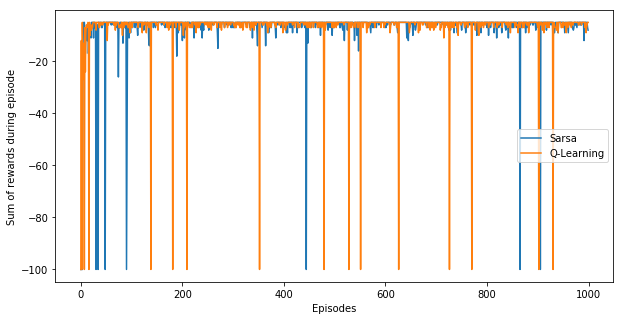

Sarsa Optimal Policy:
['R', 'U', 'R', 'G']
['U', 'U', 'U', 'U']
['U', 'L', 'L', 'D']
Q-Learning Optimal Policy:
['R', 'R', 'R', 'G']
['U', 'U', 'U', 'D']
['U', 'U', 'U', 'L']
Rewards for Sarsa [-100. -100. -100. -100.  -17.   -7.   -5.   -5.   -9.  -17.   -7.   -9.
  -12.  -12.   -7.  -17.  -11.   -7.   -7.   -9.  -11.   -5.   -7.   -5.
   -5.  -11.   -5.   -7.   -5.   -6. -100.   -7.   -6.   -6. -100.   -5.
   -5.   -6.   -5.   -5.   -5.   -7.   -7.   -6.   -5.   -5.   -5.   -5.
 -100.   -9.   -5.   -5.   -5.   -5.   -5.   -5.   -5.   -5.   -5.   -5.
   -6.   -5.   -5.   -5.   -6.   -5.   -5.   -5.   -5.   -5.   -5.   -7.
   -5.   -7.  -26.   -6.   -7.   -5.   -5.   -5.   -7.   -7.   -6.  -13.
   -5.   -6.   -5.   -7.   -7.   -5. -100.  -50.   -7.   -7.   -5.  -11.
   -5.   -6.   -9.   -5.   -5.   -5.   -7.   -5.   -5.   -5.   -5.   -7.
   -5.   -5.   -5.   -7.  -10.   -5.   -7.   -5.   -5.   -5.   -5.   -7.
   -5.   -7.   -5.   -6.   -8.   -7.   -5.   -5.   -6.   -5.   -6.   -5.
   -

In [104]:
figure_6_4()